In [ ]:
### 4C16 Lab 4 - Feedforward Neural Nets for Image Classification.
# see handout-05
# https://frcs.github.io/4C16-LectureNotes/


In [ ]:
# Note: the training will run faster if you run your notebook as a GPU instance.
# to change to GPU mode, you need to go in the colab menu to Runtime>Change runtime type
# then select "hardware accelerator" to GPU.
# This will restart your instance (obviously), so everytime you do this you'll need to
# start your again from the start of the notebook.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/4c16-labs/code/lab-04/

Mounted at /content/gdrive
/content/gdrive/MyDrive/4c16-labs/code/lab-04


In [2]:
# Import the necessary modules

import tensorflow.keras as keras
from tensorflow.keras import datasets
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Add
from tensorflow.keras.regularizers import l2

from tensorflow.keras.models import model_from_json

from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator

import pickle
import sklearn as skl

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

In [3]:
# Define some useful functions
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        self.i += 1

        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121)
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();

def save_model_to_disk():
    # save model and weights (don't change the filenames)
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model.h5")
    print("Saved model to model.json and weights to model.h5")

In [ ]:
# loading dataset

!curl --create-dirs -o /home/tcd/data/cifar10-dataset.pkl https://tcddeeplearning.blob.core.windows.net/deeplearning202324/cifar10-dataset.pkl

loading the dataset...
loaded.
let's look at some of the pictures and their ground truth labels:


<ipython-input-4-7496728c9f58>:29: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,i+1)


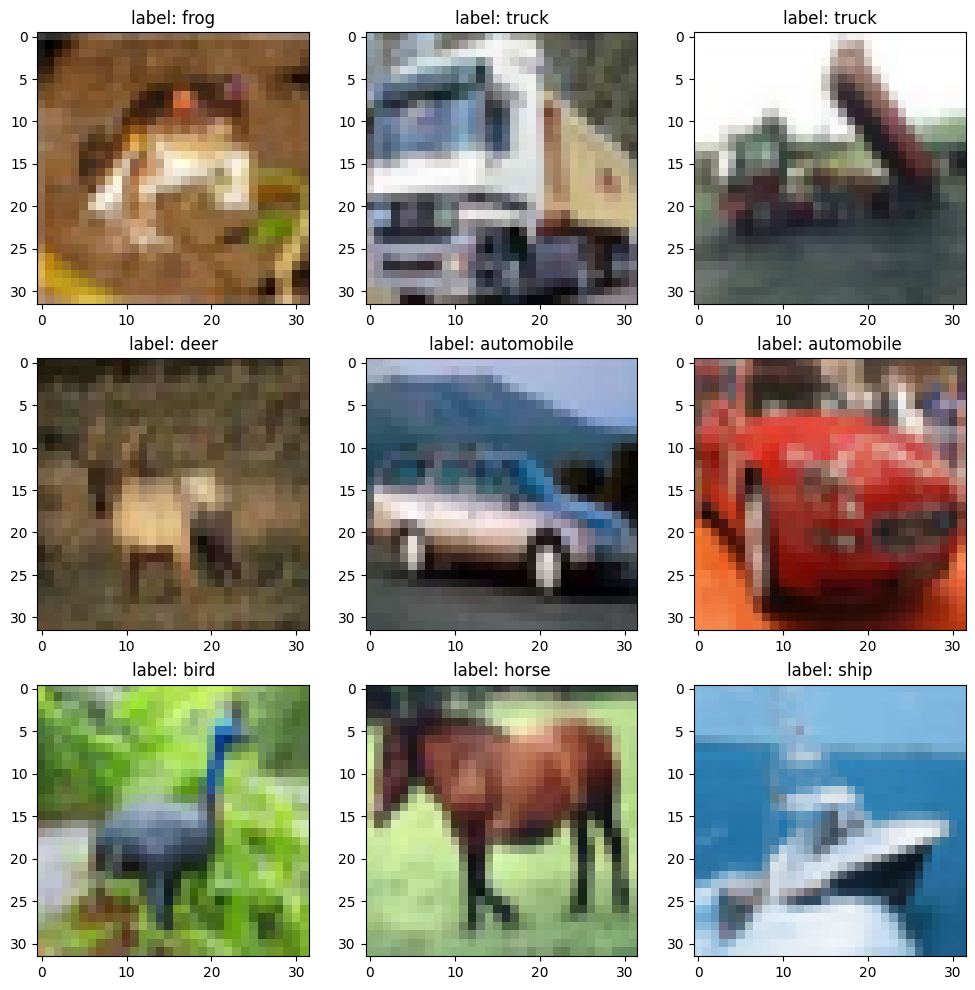

In [4]:
print('loading the dataset...')

pkl_file = open('cifar10-dataset.pkl', 'rb')
dataset = pickle.load(pkl_file)

print('loaded.')

print('let\'s look at some of the pictures and their ground truth labels:')

plt.figure(figsize=(12,12))
plt.plot([3, 3])

X = dataset['X'].astype('float32')/255
Y = dataset['Y'].astype('float32')
Y = keras.utils.to_categorical(Y)

for i in range(0,9):
    # pictures are 32x32x3 (width=32, height=32, 3 colour channels)
    pic = X[i]

    # Y[i] returns an array of zeros and with Y[i][classid] = 1
    # for instance  Y[i] = [ 0 0 0 0 0 1 0 0 0 0] => classid=5
    #          and  Y[i] = [ 1 0 0 0 0 0 0 0 0 0] => classid=0
    # we can get the classid by using the argmax function on the vector Y[i]
    classid = Y[i].argmax(-1)

    # getting back the name of the label for that classid
    classname = dataset['labels'][classid]
    plt.subplot(3,3,i+1)
    plt.imshow(pic)
    plt.title('label: {}'.format(classname))


In [5]:
# let's split data between validation set and training set

X_train, X_validation, Y_train, Y_validation = skl.model_selection.train_test_split(X, Y, test_size=.3)

In [ ]:
# the data structure is a tensor, ie. it is a multidimensional array
# each layer instance is callable on a tensor, and returns a tensor

# The model below contains 2 hidden layers with 30 nodes each.
# The activation functions for these 2 layers is the ReLU
# The network ends with a 10 nodes layer with softmax activation
# The first 2 hidden layers transform the original features into
# a new feature vector of size 30.
# The last layer essentially does the classification using multonomial regression
# based on these new features.

inputs = keras.layers.Input(shape=(32, 32, 3))
x = Flatten()(inputs)
x = Dense(30, activation='relu')(x)
x = Dense(30, activation='relu')(x)

predictions = Dense(10, activation='softmax')(x)

# we create the model
model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# setup the optimisation strategy
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

if (model.count_params() > 5000000):
    raise Exception("Your model is unecessarily complex, scale down!")


Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 flatten_34 (Flatten)        (None, 3072)              0         
                                                                 
 dense_159 (Dense)           (None, 30)                92190     
                                                                 
 dense_160 (Dense)           (None, 30)                930       
                                                                 
 dense_161 (Dense)           (None, 10)                310       
                                                                 
Total params: 93,430
Trainable params: 93,430
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# we create a callback function to plot our loss function and accuracy
pltCallBack = PlotLossAccuracy()

# and train
model.fit(X_train, Y_train,
          batch_size=1024, epochs=40,
          validation_data=(X_validation, Y_validation),
          callbacks=[pltCallBack])

# If you run this cell again, the optimisation starts where you left it.
# For instance, if you have set epochs=40 in the model.fit call,
# and that you run the cell 3 times, then you are effectively running for
# 120 iterations.

In [ ]:
# write model to model.json and weights to model.h5 for submission

save_model_to_disk()

Saved model to model.json and weights to model.h5


In [ ]:
# you can now commit and push and submit lab for assessment

<ipython-input-3-17de9260f319>:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


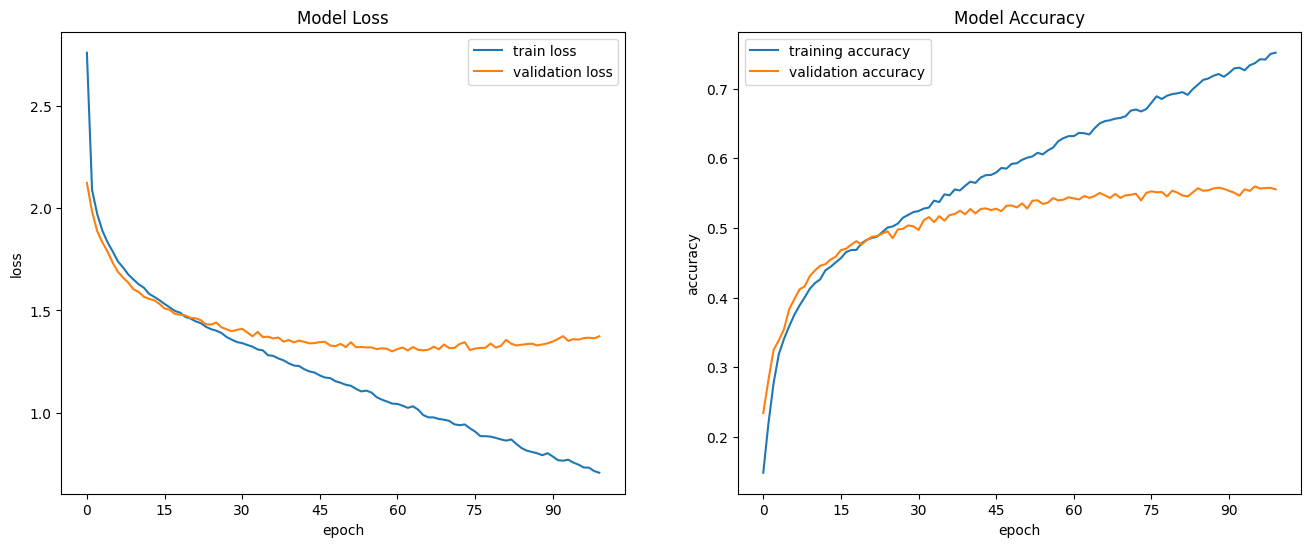

14/14 [==============================] - 4s 306ms/step - loss: 0.7069 - accuracy: 0.7517 - val_loss: 1.3736 - val_accuracy: 0.5556


In [8]:
# Question: design a network only using Dense layers and achieve 50% or more accuracy on the server's test set
#
# You may want to test the following:
#
#     adding layers,
#     changing the number of units per layer,
#     changing the activation functions,
#     changing the optimizer
#     the learning rate,
#     adding Dropout [https://keras.io/layers/core/#dropout]
#     adding Regularisers (eg. L2, L1) [https://keras.io/regularizers/]
#
# Always check on your accuray and loss graphs that that you are not overfitting.
#
# you don't need to go mad, we know you can get 55% accuracy with only 3 Dense layers.
# Also note that Deeper networks will require longer training times.
#
# Good luck!
#
# F.A.Q.
#
#   I reached 51% on my validation set, but the submission didn't pass, how come?
#     > the test set on the server is different from your validation set
#   can I use convolutional layers?
#     > No.
#

inputs = keras.layers.Input(shape=(32, 32, 3))
x = Flatten()(inputs)
x = Dense(2349, activation='relu')(x)
x = Dropout(0.21336128021302173)(x)
x = Dense(2763, activation='relu')(x)
x = Dropout(0.36794553177517775)(x)
x = Dense(2016, activation='relu')(x)
x = Dropout(0.42606044532076304)(x)
predictions = Dense(10, activation='sigmoid')(x)

# we create the model
model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.Adamax(learning_rate=0.000557755035490743) #learning_rate=0.0006 with Nadam

# setup the optimisation strategy
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


pltCallBack = PlotLossAccuracy()

# and train
model.fit(X_train, Y_train,
          batch_size=2500, epochs=100,
          validation_data=(X_validation, Y_validation),
          callbacks=[pltCallBack])

In [14]:
save_model_to_disk()

Saved model to model.json and weights to model.h5
